# Rates Simulations

Построение симуляций для моделирования поведения ключевой ставки ЦБ и ставок по кривой бескупонной доходности на различные сроки

В качестве модели будем использовать CIR

In [23]:
import random

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm.auto import tqdm

from data import DATA_PATH

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
random.seed(42)

### Чтение данных

In [4]:
all_data = pd.read_csv(DATA_PATH / 'all_data.csv', index_col='date')
all_data.head()

,su26230_days_before_coupon,su26224_days_before_coupon,su26222_days_before_coupon,su26221_days_before_coupon,su26218_days_before_coupon,ecb_rate,aluminum,brent,cbr_key_rate,eur_rub,...,rosn,rual,sber,vtbr,year_1,year_3,year_5,year_10,year_15,year_20
date,,,,,,,,,,,,,,,,,,,,,
2020-01-10,89,145,103,89,82,0.25,1806.0,65.02,6.25,68.0555,...,473.50,31.70,258.19,0.04760,5.48,5.69,5.90,6.26,6.48,6.61
2020-01-11,89,145,103,89,82,0.25,1806.0,65.02,6.25,68.0555,...,473.50,31.70,258.19,0.04760,5.48,5.69,5.90,6.26,6.48,6.61
2020-01-12,89,145,103,89,82,0.25,1806.0,65.02,6.25,68.0555,...,473.50,31.70,258.19,0.04760,5.48,5.69,5.90,6.26,6.48,6.61
2020-01-13,86,142,100,86,79,0.25,1798.0,64.23,6.25,68.0450,...,481.15,32.20,262.40,0.04806,5.45,5.64,5.84,6.18,6.39,6.52
2020-01-14,85,141,99,85,78,0.25,1809.0,64.42,6.25,67.8162,...,475.50,32.83,259.05,0.04726,5.46,5.68,5.89,6.26,6.47,6.60


In [5]:
key_rates = all_data['cbr_key_rate']

In [6]:
key_rates.describe()

count    1450.000000
mean        7.672241
std         3.355187
min         4.250000
25%         5.500000
50%         7.500000
75%         8.500000
max        20.000000
Name: cbr_key_rate, dtype: float64

### Формальная постановка задачи

Модель CIR:

$
d\ r_t = a(b - r_t)dt + \sigma \sqrt{r_t}dW_t
$

- $a$ - скорость возврата к среднему значению
- $b$ - среднее значение ставки
- $r_t$ - процентная ставка в момент времени t 
- $\sigma$ - стандартное отклонение ставки (мера волатильности)
- $dW_t$ - инкремент винеровского процесса

Разностная схема: $r_{t+1} = r_t + a(b - r_t) (T_{t+1} - T_t) + \sigma \sqrt{r_t}(W_{t+1} - W_t)$

In [7]:
def cir_sim(r_0, a, b, sigma, n_days, n_sim, deltas_W=None):
    result = np.array([r_0] * n_sim).reshape(-1, 1)
    for i in range(1, n_days + 1):
        r_prev = result[:, -1].reshape(-1, 1)
        delta_t = 1
        if deltas_W is None:
            delta_W = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=(n_sim, 1))
        else:
            delta_W = deltas_W[:, i - 1].reshape(-1, 1)
        r_t_i = r_prev + a * (b - r_prev) * delta_t + sigma * np.sqrt(r_prev) * delta_W
        r_t_i = np.clip(r_t_i, 0, 100000000)
        result = np.hstack([result, r_t_i])
    return result

### Подбор параметров модели

- Параметр $\sigma$:

Волатильность можно вычислить на основе исторических данных по следующей формуле: $\sigma = std(r_t)/\sqrt{n_{days}}$, таким образом, мы сможем численно выразить волатильность для наблюдаемых ставок на каждый день в историческом периоде 

- Параметры $a$ и $b$: 

Данные параметры можно подобрать полуавтоматическим способом – путем минимизации функции ошибок (классический МНК) при симуляции данных


In [8]:
def cir_model_opt_params(params, r, dt):
    alpha, theta, sigma = params
    dw = np.random.normal(0, np.sqrt(dt))
    dr = alpha * (theta - r) * dt + sigma * np.sqrt(r) * dw
    return dr


def objective_function(params, r):
    dt = 1 / 365  # daily interval
    cum_error = 0
    for n in range(len(r)):
        cum_error += (r[n] - cir_model_opt_params(params, r[n], dt)) ** 2
    return cum_error

In [9]:
initial_params = [0.01, key_rates.mean(), (key_rates.std()) / np.sqrt(len(key_rates))]
optimal_params = minimize(objective_function, initial_params, args=(key_rates,), method='Nelder-Mead').x

/var/folders/64/5j28s5ns6ss54c8w28jn3v2h0000gn/T/ipykernel_99100/309203029.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_error += (r[n] - cir_model_opt_params(params, r[n], dt)) ** 2


In [10]:
a_opt, b_opt, sigma_opt = map(lambda p: round(p, 2), optimal_params)
print(f'{a_opt = }')
print(f'{b_opt = }')
print(f'{sigma_opt = }')

a_opt = 0.01
b_opt = 8.13
sigma_opt = 0.09


### Построим симуляции

In [11]:
start_date = '2021-12-01'
n_days = 100
end_date = f'{pd.Timestamp(start_date) + pd.Timedelta(days=n_days):%Y-%m-%d}'

In [12]:
sample = key_rates.loc[start_date]
target = key_rates.loc[start_date:end_date]

In [13]:
key_rate_params = {
    'r_0': sample,
    'a': 0.01,
    'b': 7.85,
    'sigma': 0.11,
}

In [14]:
n_sim = 50

In [15]:
simulations = cir_sim(n_sim=n_sim, n_days=n_days, **key_rate_params)

In [16]:
simulations.shape

(50, 101)

### Отрисуем результаты

In [17]:
def plot_simulations(simulations, target, title):
    plt.figure(figsize=(10, 5))

    plt.title(f'{title} Simulations')
    plt.xlabel('Days')
    plt.ylabel('Rate')

    for sim in simulations:
        plt.plot(sim)

    plt.plot(target, color='black', label='target')

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.grid()
    plt.legend()
    plt.show()

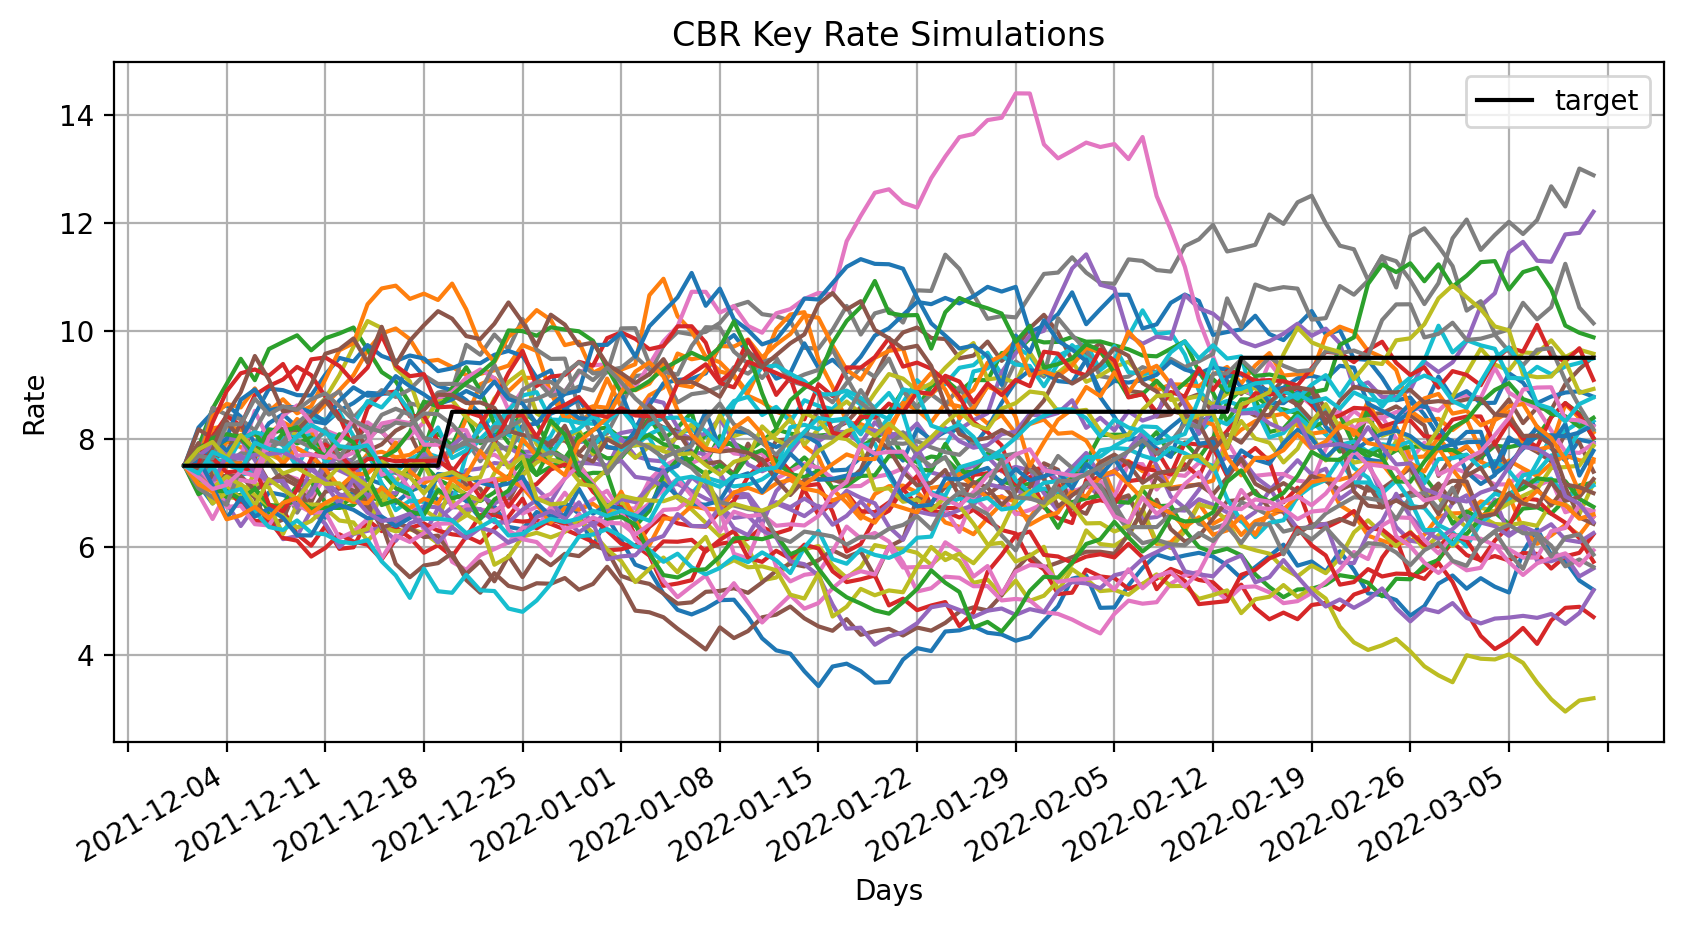

In [18]:
plot_simulations(
    simulations,
    target,
    'CBR Key Rate',
)

### Получим оптимальные параметры симуляций для всех ставок

In [25]:
opt_params = {}

for risk_factor in tqdm(
    ['year_1', 'year_3', 'year_5', 'year_10', 'year_15', 'year_20', 'cbr_key_rate'],
    desc='Optimizing params',
):
    data = all_data[risk_factor]
    initial_params = [0.01, data.mean(), (data.std()) / np.sqrt(len(data))]
    optimal_params = minimize(objective_function, initial_params, args=(data,), method='Nelder-Mead').x
    a_opt, b_opt, sigma_opt = map(lambda p: round(p, 2), optimal_params)
    opt_params[risk_factor] = {
        'a': a_opt,
        'b': b_opt,
        'sigma': sigma_opt,
    }
    
print(opt_params)

Optimizing params:   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/64/5j28s5ns6ss54c8w28jn3v2h0000gn/T/ipykernel_99100/309203029.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_error += (r[n] - cir_model_opt_params(params, r[n], dt)) ** 2


{'year_1': {'a': 0.01, 'b': 7.73, 'sigma': 0.07}, 'year_3': {'a': 0.01, 'b': 8.2, 'sigma': 0.06}, 'year_5': {'a': 0.01, 'b': 7.99, 'sigma': 0.06}, 'year_10': {'a': 0.01, 'b': 8.75, 'sigma': 0.06}, 'year_15': {'a': 0.01, 'b': 9.04, 'sigma': 0.05}, 'year_20': {'a': 0.01, 'b': 9.46, 'sigma': 0.05}, 'cbr_key_rate': {'a': 0.01, 'b': 8.06, 'sigma': 0.09}}
